In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import *
from scipy.sparse import linalg

In [10]:
def laplacian(n):
    """
    Function to create a square discretization matrix
    for the Laplacian in cartesian coordinates.
    ...

    Args
    ----------
    int n : Size of each coordinate.
    ...

    Returns
    ----------
    scipy.sparse C : The discretization matrix of size ((n*n),(n*n))
    """
    dx = 1.0 / (n+1)
    I = diags([np.ones(n-1),np.ones(n-1)],[-1,1])
    B = eye(n)
    A = diags([np.ones(n-1),-4*np.ones(n),np.ones(n-1)], [-1,0,1])
    C = (kron(I, B) + kron(B, A))/dx**2
    return C

In [40]:
def heat_source(x, y):
    """
    Heat source for the heating plate problem.
    Gaussian distribution.

    Args
    ----------
    float x, float y: Mesh location.

    Returns
    ----------
    float: Input heat in the mesh point x,y.
    """
    xs = 1.0 / 2.0
    ys = 1.0 / 2.0
    w = 0.1
    return np.exp(-((x - xs)**2 + (y - ys)**2) / w**2)

In [41]:
def heating_plate(Q, S, t):
    """
    Heating plate function to be integrated in the ivp.

    Args
    ---------
    np.array Q : heat in each mesh point.
    np.array S : heat source in each mesh point.

    Returns
    ---------
    np.array : Equation of the heating plate applied to each mesh point.
    """

    n = int(np.sqrt(len(Q)))
    L  = laplacian(n)
    return csr_matrix.dot(L, Q)+ S

In [62]:
mesh_size = 100
Lx = 1.0
Ly = 1.0
x = np.linspace(0, Lx, mesh_size + 2)
y = np.linspace(0, Ly, mesh_size + 2)
alpha = 1.0 # Diffusivity
dx, dy = Lx / (mesh_size+1), Ly / (mesh_size+1)  # Control volume
dt = 0.25 * min(dx**2, dy**2) #/ alpha  # Time step size (CFL condition)

X, Y = np.meshgrid(x, y)
S = heat_source(X, Y)[1:-1, 1:-1].flatten()

T = 0.1
Nt = int(T / dt)  # Number of time steps
Q = np.zeros((mesh_size + 2, mesh_size + 2))
q_new = np.zeros_like(Q)



In [63]:
for n in range(Nt):
    q_flat = Q[1:-1, 1:-1].flatten()

    # Solve for the new time step
    aux = heating_plate(q_flat, S, dt)
    q_flat_new = q_flat + dt * (aux)
    q_flat_new = q_flat + 0.5 * dt * ((aux) + heating_plate(q_flat_new, S, dt))

    # Reshape back to 2D array
    q_new[1:-1, 1:-1] = q_flat_new.reshape((mesh_size, mesh_size))

    # Apply Neumann boundary conditions (zero gradient)
    q_new[0, :] = q_new[1, :]         # Bottom boundary
    q_new[-1, :] = q_new[-2, :]       # Top boundary
    q_new[:, 0] = q_new[:, 1]         # Left boundary
    q_new[:, -1] = q_new[:, -2]       # Right boundary

    # Update q
    Q[:, :] = q_new[:, :]

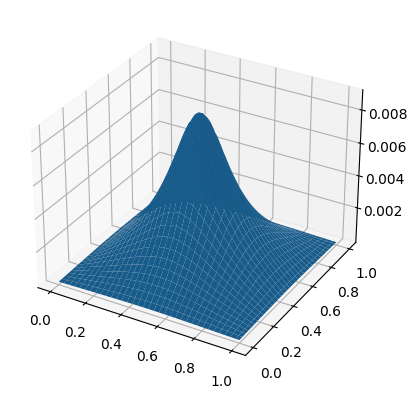

In [64]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, Q)
plt.show()